<h1 id="header-1">1. The Academy Awards Project</h1>

The Academy Awards have long been a staple when it comes to awarding the best movies that comes out each year. But in 2020 one movie stood out as the most controversial best picture winner in history. 

Parasite is a korean thriller/drama movie directed by Bong Joon-ho. Its Oscar win was a surprise to many and it is a clear outlier when looking back at previous winners. And this leads to some questions:<br>

* What factors made this Oscar win so unexpected?
* Do the Oscar nominated/winning movies create a well connected network of some underlying factors? 
* Is Parasite a clear outlier in this network? 
* Can this network be used to predict whether other movies will do well?
* Is there a specific plot (underlying sentiment) that can guarantee an Oscar win?

With a mix of both network analysis and natural language processing, this report will dive into a network of Oscar Movies and try to answer these questions.

# 2. Data Extraction And Cleaning
First we import all the packages that we use in this notebook.

In [1]:
from imdb import IMDb
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import re
#import urllib.request
import io
#import requests
#import json, urllib
import os
import pandas as pd
#import community
#from operator import itemgetter
from nltk.corpus import stopwords
import nltk
import math
from wordcloud import WordCloud
#from statistics import mean

<h2 id="header-3">2.1. IMDbPY Package - A Short Guide</h2>

IMDb is the Internet Movie Database and as of January 2020, it has approximately 6.5 million titles. The individual movie pages contain information such as realease year, plot outline, cast and crew. This makes it the most useful website for extracting movie details that we would use in our network.

To make the work of extracting information even more simple we use the [IMDbPY](https://imdbpy.readthedocs.io/en/latest/index.html) package so that we can get exactly the information we need instead of sorting through long codes and texts. Here is a short "how to" guide:

In [2]:
# creates an instance of the IMDb class
ia = IMDb()

We can now search for any movie we want here. As an example we'll try my favorite movie.

In [3]:
movie = ia.search_movie('Goodfellas')
print(len(movie))
movie[1:5]

20


[<Movie id:2180383[http] title:_Goodfellas (in development) (None) (TV)_>,
 <Movie id:12395564[http] title:_"WingMen" Goodfellas (2019)_>,
 <Movie id:11387646[http] title:_GoodFellas... Where Loyalty Matters! (2019)_>,
 <Movie id:11659334[http] title:_GoodFellas: Now En Español! (2019)_>]

We now get a list of 20 movies with "Goodfellas" in the title. And if the title is written right it's usually the first movie in the list we're interested in. Now we can take movie ID and extract it's information.

In [4]:
goodfella = ia.get_movie(movie[0].movieID)

Each movie instance has a current_info attribute for tracking the information sets that have already been retrieved. This consist of the main information (listed below), plot and synopsis. 

In [5]:
goodfella.current_info

['main', 'plot', 'synopsis']

In [6]:
print(goodfella.infoset2keys)

{'main': ['original title', 'cast', 'genres', 'runtimes', 'countries', 'country codes', 'language codes', 'color info', 'aspect ratio', 'sound mix', 'box office', 'certificates', 'original air date', 'rating', 'votes', 'cover url', 'imdbID', 'plot outline', 'languages', 'title', 'year', 'kind', 'directors', 'writers', 'producers', 'cinematographers', 'editors', 'editorial department', 'casting directors', 'production designers', 'art directors', 'set decorators', 'costume designers', 'make up department', 'production managers', 'assistant directors', 'art department', 'sound department', 'special effects', 'visual effects', 'stunts', 'camera department', 'casting department', 'costume departmen', 'location management', 'music department', 'script department', 'transportation department', 'miscellaneous', 'akas', 'writer', 'director', 'top 250 rank', 'production companies', 'distributors', 'other companies'], 'plot': ['plot', 'synopsis']}


We can now retrieve the any of the main info as such:

In [7]:
goodfella['genres']

['Biography', 'Crime', 'Drama']

## 2.2. Data Specification And Extraction
According to the Motion Picture Association of America, an average of 600 movies are released per year. And last year 53 movies were nominated for an Oscar. So if we had to create a network of ALL Oscar nominated movies as nodes this would give us a very big network. But we'll instead focus on the main category. Best picture. The list of best picture nominees and winners is taken from [Wikipedia](https://en.wikipedia.org/wiki/Academy_Award_for_Best_Picture) and made into an excel file. There are **562 movies** that have been nominated and of those there are **91 winners**.

Now for the attributes. 
By taking inspiration from the Business Insider article [There's a formula to winning the Oscars, and it's all in the statistics](https://www.businessinsider.com/oscars-academy-awards-rigged-best-picture-nominations-win-2019-2?r=US&IR=T), we choose to extract the folowing attributes from IMDb. Genre, production company and director because according to the article these three attributes play a big factor when it comes to winning. We will extract the plot outline as well for the text analysis. 

In [8]:
m_frame = pd.read_excel('Oscar list.xlsx')
m_frame["Year"] = ""
m_frame["Genre"] = ""
m_frame["Production Company"] = ""
m_frame["Director"] = ""
m_frame["Plot"] = ""

In [9]:
print(m_frame.shape)
m_frame.head()

(562, 7)


,Movie,Nominee/Winner,Year,Genre,Production Company,Director,Plot
0,12 Years a Slave,Winner,,,,,
1,A Beautiful Mind,Winner,,,,,
2,A Man for All Seasons,Winner,,,,,
3,All About Eve,Winner,,,,,
4,All Quiet on the Western Front,Winner,,,,,


Here is the code we use for the data extraction. <br>Depending on the speed of your internet this can take from 20 to 40 minutes, so we save the dataframe in a pickle so that we can access it quicker. 
Some of the information that we are interested in is not present in some of the more older movies, but because we will end up with a big network, we can ignore them without loosing important stats at the end. 

In [ ]:
for index, row in m_frame.iterrows():
    movie = row['Movie']
    if movie == 1917:
        movie = str(movie)
    search = ia.search_movie(movie)
    movieId = search[0].movieID
    info = ia.get_movie(movieId)
    
    if 'year' in info:
        row['Year'] = info['year']
        
    prod_comp = []
    if 'production companies' in info:
        for prod in info['production companies']:
            prod_comp.append(str(prod))
    row['Production Company'] = prod_comp
    
    genr = []
    for genre in info['genre']:
        genr.append(genre)
    row['Genre'] = genr
    
    direc =[]
    if 'directors' in info:
        for director in info['directors']:
            direc.append(str(director))
        
    row['Director'] = direc
    if 'plot outline' in info:
        row['Plot'] = info['plot outline']
    else:
        row['Plot'] = 'None'

In [ ]:
m_frame.to_pickle("OscarMovies-")

In [10]:
m_frame = pd.read_pickle('OscarMovies')

In [11]:
m_frame.to_excel("m_frame.xlsx") #Also saving it as an excel file for the website

In [12]:
m_frame.head()

,Movie,Nominee/Winner,Year,Genre,Production Company,Director,Plot
0,12 Years a Slave,Winner,2013,"[Biography, Drama, History]","[New Regency Productions, River Road Entertain...",[Steve McQueen],Based on an incredible true story of one man's...
1,A Beautiful Mind,Winner,2001,"[Biography, Drama]","[Universal Pictures, Dreamworks Pictures, Imag...",[Ron Howard],From the heights of notoriety to the depths of...
2,A Man for All Seasons,Winner,1966,"[Biography, Drama, History]",[Highland Films],[Fred Zinnemann],The story takes place in sixteenth century Eng...
3,All About Eve,Winner,1950,[Drama],[Twentieth Century Fox],[Joseph L. Mankiewicz],Eve Harrington (Anne Baxter) is waiting backst...
4,All Quiet on the Western Front,Winner,1930,"[Drama, War]",[Universal Pictures],[Lewis Milestone],This is an English language film (made in Amer...


# 3. The Academy Awards Network
Now that all of the data has been collected we can create each movie as a node and add the attributes as edges. With this method we can visualize how the movies are connected and how this network behaves.

## 3.1. Building The Network
Each movie node will have the Nominee/Winner attribute. And when we add the edges will make sure to save what atrribute each edge belongs to so that we can differentiate from them later. <br>
The network will be an undirected graph without multiple edges (except if they have a different attribute). We chose to model it as an undirected graph because we're not interested in what direction the movies are connected but rather what edge attribute links them. 

In [13]:
G = nx.Graph()
for index, row in m_frame.iterrows():
    movie = row['Movie']
    win = row['Nominee/Winner'] #defining node atttribute
    G.add_node(movie, iswin = win)

Since edges are only added if they don't actually exist, we don't have to take into consideration if they are added multiple times.

In [14]:
for index, row in m_frame.iterrows():
    movie = row['Movie']
    if movie == 1917: #Numbers give us troubles accessing rows
        movie = str(movie)
    subset = pd.DataFrame() 
    subset = m_frame[m_frame['Movie']!=movie] #We don't need self loops
    for index2, row2 in subset.iterrows():
        movie2 = row2['Movie']
        for dir1 in row['Director']:
            for dir2 in row2['Director']:
                if dir1 == dir2: #adding edges if same director
                    G.add_edge(movie, movie2, attribute = "Director", name = dir1)
                    
        for genr1 in row['Genre']:
            for genr2 in row2['Genre']:
                if genr1 == genr2: #adding edges if same genre 
                    G.add_edge(movie, movie2, attribute = "Genre", name = genr1) 
                    
        for prod1 in row['Production Company']:
            for prod2 in row2['Production Company']:
                if prod1 == prod2: #adding edges if same production company
                    G.add_edge(movie, movie2, attribute = "Production", name = prod1)    

We will now create node and edge lists so that we can analyze the different attributes.

In [15]:
winnodes = []
nomnodes = []
allnodes = []
pos=nx.spring_layout(G)
for i in G.nodes:
    try:
        if G.nodes[i]['iswin'] == "Winner":
           # pos[i][1] += 3
            winnodes.append(i)
        else:
            nomnodes.append(i)
    except KeyError:
        continue
allnodes = winnodes+nomnodes
        
genedges = []
prodedges = []
diredges = []

for i in G.edges:
    if G.edges[i]['attribute'] == "Genre":
        genedges.append(i)
    elif G.edges[i]['attribute'] == "Director":
        diredges.append(i)
    else:
        prodedges.append(i)

When we will be looking at the genre network it would be more visually pleasing if every genre edge has it's own color, so therefore we create further edgelists so that we can differ for genre. <br>
After some backend preprocessing of the dataframe (basically saying that we did in excel) we have taken out each unique genre and created a list.

In [16]:
genre = pd.read_excel('Genrelist.xlsx')
len(genre)
gen_edge_lists = [[] for x in range(len(genre))] 

In [17]:
for index, row in genre.iterrows():
    gen = row['Genre']
    for i in G.edges:
        if G.edges[i]['attribute'] == "Genre":
            if G.edges[i]['name'] == gen:
                gen_edge_lists[index].append(i)

We are now going to create 3 subgraphs. One for each atttribute.

In [41]:
G1 = nx.Graph(diredges)
G1.add_nodes_from(allnodes)
G2 = nx.Graph(genedges)
G2.add_nodes_from(allnodes)
G3 = nx.Graph(prodedges)
G3.add_nodes_from(allnodes)

## 3.2. Network Stats And Degree Distributions
Now for some basic statistics about the network. 

In [19]:
print("Number of nodes: " + str(G.number_of_nodes()))
print("Number of edges: " + str(G.number_of_edges()))

Number of nodes: 556
Number of edges: 129428


There are alot of edges and it will create a very dense network. Which is why we divided the graph into subgraphs.

We can see that we are a few movies short of the initial 562 movies we started with. This is because some movies are remade and still manage to get nominated/win. When we extracted the data with the IMDbPy package, we always chose the first movie in the search list. And if two movies have the exact same title the database will show the newest one first. So when we meant to get the 1933 movie 'Little Women' we actually got the 2019 adaptation twice, as seen below. Networkx doesn't add a node twice so there were 6 movies that have shared names. Since our network is already really big we can ignore these 6 movies. 

In [20]:
m_frame[m_frame['Movie']=="Little Women"]

,Movie,Nominee/Winner,Year,Genre,Production Company,Director,Plot
304,Little Women,Nominee,2019,"[Drama, Romance]","[Columbia Pictures, New Regency Productions, P...",[Greta Gerwig],"In the years after the Civil War, Jo March (Sa..."
305,Little Women,Nominee,2019,"[Drama, Romance]","[Columbia Pictures, New Regency Productions, P...",[Greta Gerwig],"In the years after the Civil War, Jo March (Sa..."


When we look at the number of edges based on attribute, it is clear that what connects the movies the most is genre. We are very close to getting a complete graph of $\frac{n(n-1)}{2}=\frac{556\cdot(556-1)}{2}$ = 154290 edges! <br>So it will be very interesting to see how this network behaves, but we expect to behave like a random network where we will get a peak count of nodes around the average degree.

In [21]:
print("Number of edges in the directors network: " + str(len(diredges)))
print("Number of edges in the genre network: " + str(len(genedges)))
print("Number of edges in the production network: " + str(len(prodedges)))

Number of edges in the directors network: 34
Number of edges in the genre network: 122039
Number of edges in the production network: 7355


We will now look at how well connected the movies are and their degree distributions.

In [22]:
d = sorted(G.degree, key=lambda x: x[1], reverse=True)
d1 = sorted(G1.degree, key=lambda x: x[1], reverse=True)
d2 = sorted(G2.degree, key=lambda x: x[1], reverse=True)
d3 = sorted(G3.degree, key=lambda x: x[1], reverse=True)

In [23]:
print("5 most connected movies: (total degree)")
print(d[0:5])
print(" ")
print("5 most connected movies: (by director)")
print(d1[0:5])
print(" ")
print("5 most connected movies: (by genre)")
print(d2[0:5])
print(" ")
print("5 most connected movies: (by production company)")
print(d3[0:5])

5 most connected movies: (total degree)
[('The Shape of Water', 541), ('The Goodbye Girl', 539), ('The Talk of the Town', 539), ('Mutiny on the Bounty', 537), ('Shanghai Express', 537)]
 
5 most connected movies: (by director)
[('How the West Was Won', 8), ('Raiders of the Lost Ark', 7), ('The Wizard of Oz', 5), ('Jaws', 4), ('West Side Story', 2)]
 
5 most connected movies: (by genre)
[('7th Heaven', 535), ("Prizzi's Honor", 533), ('Parasite', 532), ('Ivanhoe', 532), ('The Private Life of Henry VIII', 532)]
 
5 most connected movies: (by production company)
[('Extremely Loud & Incredibly Close', 115), ('The Curious Case of Benjamin Button', 113), ('The Towering Inferno', 106), ('The Goodbye Girl', 103), ('Titanic', 91)]


"The Shape of Water" managed to get 6 more connections from the highest ranked in genre "7th heaven". Which is further proof that the total network mostly consists of the genre network. 
The network with least connections is the directors network. With the method that we have chosen to build up the graph we can't for say if it is because one director rules them all, because in the case of 'How the West Was Won' there were multiple directors, hence more movies to be linked with.

We did not expect Parasite to be part of any of the top 5's, but it still managed to get in because of genre. In fact when we look closer hadn't it been for genre parasite wouldn't have been a part of the network at all.

From above we see that in the physical sense of director and production company "Parasite" is a true outlier. But it seems that if a movie is a special genre it gets to be a part of the network. We will look further into that in the visualization.

We will now take a look at degree distributions and see how they compare when looking at network analytics.

In [26]:
k = [val for (node, val) in sorted(G.degree, key=lambda x: x[1], reverse=True)]
k1 = [val for (node, val) in sorted(G1.degree, key=lambda x: x[1], reverse=True)]
k2 = [val for (node, val) in sorted(G2.degree, key=lambda x: x[1], reverse=True)]
k3 = [val for (node, val) in sorted(G3.degree, key=lambda x: x[1], reverse=True)]
print("Average degree of the movie network " +str(np.mean(k)))
print("Average degree of the director network " +str(np.mean(k1)))
print("Average degree of the genre network " +str(np.mean(k2)))
print("Average degree of the production network " +str(np.mean(k3)))

Average degree of the movie network 465.568345323741
Average degree of the director network 1.619047619047619
Average degree of the genre network 438.98920863309354
Average degree of the production network 30.903361344537814


In [27]:
degree_all = [val for (node, val) in sorted(G.degree, key=lambda x: x[1], reverse=True)] 
degree1 = [val for (node, val) in sorted(G1.degree, key=lambda x: x[1], reverse=True)] 
degree2 = [val for (node, val) in sorted(G2.degree, key=lambda x: x[1], reverse=True)] 
degree3 = [val for (node, val) in sorted(G3.degree, key=lambda x: x[1], reverse=True)] 

In [28]:
v = np.arange(start = min(degree_all), stop = max(degree_all)+1, step = 1)
hist, bins = np.histogram(degree_all, bins = v)

v1 = np.arange(start = min(degree1), stop = max(degree1)+1, step = 1)
hist1, bins1 = np.histogram(degree1, bins = v1)

v2 = np.arange(start = min(degree2), stop = max(degree2)+1, step = 1)
hist2, bins2 = np.histogram(degree2, bins = v2)

v3 = np.arange(start = min(degree3), stop = max(degree3)+1, step = 1)
hist3, bins3 = np.histogram(degree3, bins = v3)

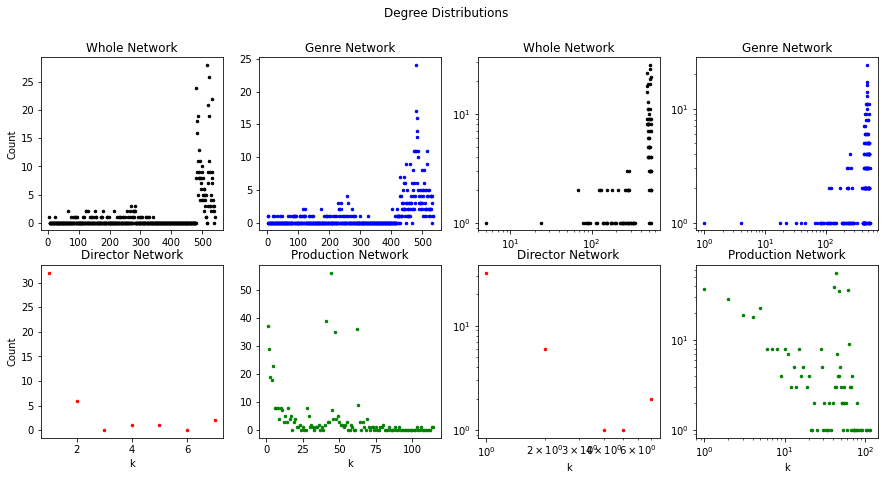

In [29]:
fig, axs = plt.subplots(2,4,figsize=(15,7))
fig.suptitle('Degree Distributions')
axs[0,0].title.set_text('Whole Network')
axs[0,0].plot(bins[:-1],hist,'o',color='black', markersize=2.5)
axs[0,0].set_ylabel("Count")
axs[1,0].set_ylabel("Count")
axs[1,0].set_xlabel("k")
axs[1,0].title.set_text("Director Network")
axs[1,0].plot(bins1[:-1],hist1,'o',color='red', markersize=2.5)
axs[0,1].title.set_text("Genre Network")
axs[0,1].plot(bins2[:-1],hist2,'o',color='blue', markersize=2.5)
axs[1,1].set_xlabel("k")
axs[1,1].title.set_text('Production Network')
axs[1,1].plot(bins3[:-1],hist3,'o', color='green', markersize=2.5)

axs[0,2].title.set_text('Whole Network')
axs[0,2].loglog(bins[:-1],hist,'o',color='black', markersize=2.5)
axs[1,2].title.set_text("Director Network")
axs[1,2].set_xlabel("k")
axs[1,2].loglog(bins1[:-1],hist1,'o',color='red', markersize=2.5)
axs[0,3].title.set_text("Genre Network")
axs[0,3].loglog(bins2[:-1],hist2,'o',color='blue', markersize=2.5)
axs[1,3].set_xlabel("k")
axs[1,3].title.set_text('Production Network')
axs[1,3].loglog(bins3[:-1],hist3,'o', color='green', markersize=2.5)
plt.show()

From the above graphs we see a very unclear picture of how the network behaves:

The overall network is ruled by genre, and from looking at the genre network we it seems to follow a 

In [30]:
N = 556
p = 0.8
ER = nx.gnp_random_graph(N, p)

degree_ER = [val for (node, val) in sorted(ER.degree(), key=lambda pair: pair[0])] 

v5 = np.arange(start = min(degree_ER), stop = max(degree_ER)+1, step = 1)
hist5, bins5 = np.histogram(degree_ER, bins = v5)

In [31]:
k = [val for (node, val) in sorted(G2.degree, key=lambda x: x[1], reverse=True)]
np.mean(k)

438.98920863309354

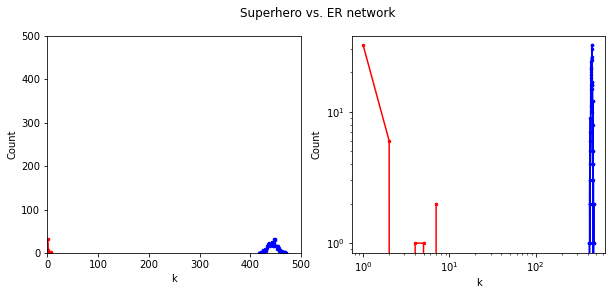

In [32]:
fig, axs2 = plt.subplots(ncols=2, figsize=(10,4))
fig.suptitle('Superhero vs. ER network')
axs2[0].plot(bins1[:-1],hist1,'-o',color='red', markersize=2.5)
axs2[0].plot(bins5[:-1],hist5,'-o',color='blue', markersize=2.5)
axs2[0].axis(xmin=0,xmax=100)
axs2[0].axis(ymin=0,ymax=300)
axs2[0].set_ylabel("Count")
axs2[0].axis([0,500,0,500])
axs2[0].set_xlabel("k")
axs2[1].loglog(bins1[:-1],hist1,'-o', color='red', markersize=2.5)
axs2[1].loglog(bins5[:-1],hist5,'-o', color='blue', markersize=2.5)
axs2[1].set_ylabel("Count")
axs2[1].set_xlabel("k")
plt.show()

## 3.3 Network Visualization


In [39]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0.5,

                        # Performance
                        jitterTolerance=0.2,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.6,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=5.0,
                        strongGravityMode=False,
                        gravity=1,

                        # Log
                        verbose=True)

positions1 = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:00<00:00, 3451.54it/s]


BarnesHut Approximation  took  0.11  seconds
Repulsion forces  took  0.37  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.04  seconds


  0%|          | 0/2000 [00:00<?, ?it/s]

BarnesHut Approximation  took  3.17  seconds
Repulsion forces  took  37.64  seconds
Gravitational forces  took  0.18  seconds
Attraction forces  took  16.83  seconds
AdjustSpeedAndApplyForces step  took  0.70  seconds


100%|██████████| 2000/2000 [00:32<00:00, 61.02it/s]

BarnesHut Approximation  took  3.15  seconds
Repulsion forces  took  27.18  seconds
Gravitational forces  took  0.12  seconds
Attraction forces  took  1.09  seconds
AdjustSpeedAndApplyForces step  took  0.61  seconds


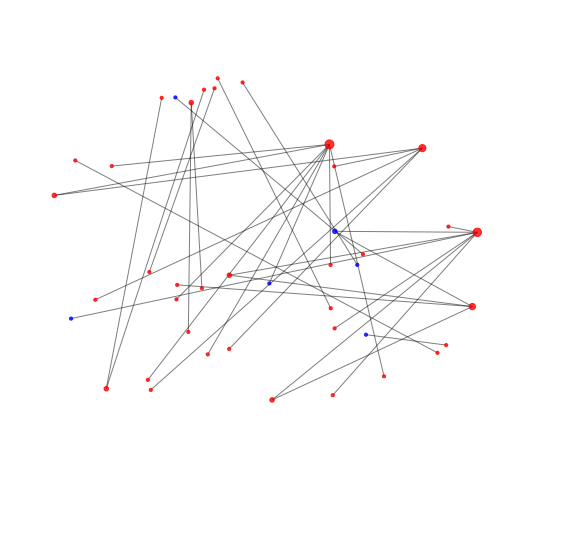

In [49]:
degr1 = [val for (node, val) in G1.degree(winnodes)]
degr2 = [val for (node, val) in G1.degree(nomnodes)]

plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G, positions, with_labels=True, nodelist=winnodes, 
    node_color="b", node_size=[v * 10 for v in degr1], alpha = 0.8)

nx.draw_networkx_nodes(G, positions, with_labels=False, nodelist=nomnodes, 
    node_color="r", node_size=[v * 10 for v in degr2], alpha = 0.8,)


nx.draw_networkx_edges(G, positions, edgelist = diredges, width=1, alpha=0.5,
    edge_color="black")

plt.axis("off")
plt.show()

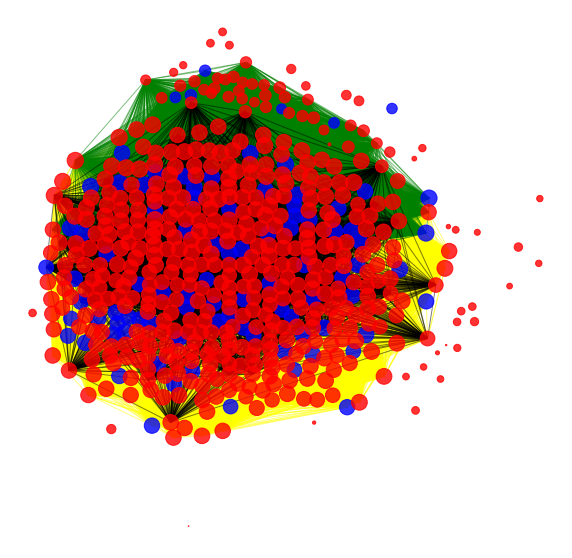

In [43]:
degr1 = [val for (node, val) in G2.degree(winnodes)]
degr2 = [val for (node, val) in G2.degree(nomnodes)]

plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G, positions, with_labels=True, nodelist=winnodes, 
    node_color="b", node_size=[v * 0.5 for v in degr1], alpha = 0.8)

nx.draw_networkx_nodes(G, positions, with_labels=False, nodelist=nomnodes, 
    node_color="r", node_size=[v * 0.5 for v in degr2], alpha = 0.8,)

nx.draw_networkx_edges(G, positions, edgelist = gen_edge_lists[7], width=1, alpha=0.5,
    edge_color="yellow")
nx.draw_networkx_edges(G, positions, edgelist = gen_edge_lists[17], width=1, alpha=0.5,
    edge_color="green")
nx.draw_networkx_edges(G, positions, edgelist = gen_edge_lists[21], width=1, alpha=0.5,
    edge_color="black")

plt.axis("off")
plt.show()

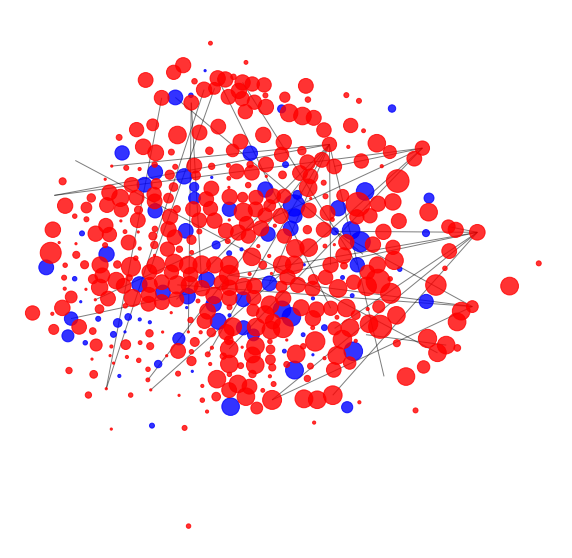

In [51]:
degr1 = [val for (node, val) in G3.degree(winnodes)]
degr2 = [val for (node, val) in G3.degree(nomnodes)]

plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G, positions, with_labels=True, nodelist=winnodes, 
    node_color="b", node_size=[v * 5 for v in degr1], alpha = 0.8)

nx.draw_networkx_nodes(G, positions, with_labels=False, nodelist=nomnodes, 
    node_color="r", node_size=[v * 5 for v in degr2], alpha = 0.8,)


nx.draw_networkx_edges(G, positions, edgelist = diredges, width=1, alpha=0.5,
    edge_color="black")

plt.axis("off")
plt.show()

In [ ]:
for list in gen_edge_lists:
    print(len(list))

# 4. Text Analysis
We can now look at the plot outline for each of the movies and find out if the best picture winning movies are 

In [ ]:
stop_words = (stopwords.words('english')) 

In [ ]:
win_word = []
for index, row in m_frame.iterrows():
    iswin = row['Nominee/Winner']
    if iswin == "Winner":
        plot = row['Plot']
        words = re.findall(r"([\w'-]+)", plot)
        newWords = [ch.lower() for ch in words if ch.isalpha()] # Remove words containg punctuation and make the words lower case
        newWords1 = [ch1 for ch1 in newWords if ch1 not in stop_words]  # Remove words that appear in the list stop_words.
        win_word = newWords1 + win_word # Make a string with all the lower case words.

    

In [ ]:
nom_word = []
for index, row in m_frame.iterrows():
    iswin = row['Nominee/Winner']
    if iswin == "Nominee":
        plot = row['Plot']
        words = re.findall(r"([\w'-]+)", plot)
        newWords = [ch.lower() for ch in words if ch.isalpha()] # Remove words containg punctuation and make the words lower case
        newWords1 = [ch1 for ch1 in newWords if ch1 not in stop_words]  # Remove words that appear in the list stop_words.
        nom_word = newWords1 + nom_word # Make a string with all the lower case words.

In [ ]:
len(win_word)

In [ ]:
FreqWin=(nltk.FreqDist(win_word))
FreqNom=(nltk.FreqDist(nom_word))

In [ ]:
print("10 most common words in the Marvel universe")
FreqWin.most_common(10)

In [ ]:
print("10 most common words in the Marvel universe")
FreqNom.most_common(10)

In [ ]:
TFTRWin ={} 
c=100
for k in FreqWin.keys(): #Loop through words
    try: # Calculate w if word is in both universes
        w=Freqwin[k]/(FreqNom[k]+c) 
    except: # Calculate w if word is only in Marvel
        w=FreqWin[k]/c
    TFTRWin[k]=[FreqWin[k],w,w*FreqWin[k]]

In [ ]:
TFTRNom ={}
c=1000
for k in FreqNom.keys():#Loop through words
    try:  # Calculate w if word is in both universes
        w=FreqNom[k]/(FreqWin[k]+c)
    except: # Calculate w if word is only in DC
        w=FreqDC[k]/c
    TFTRNom[k]=[FreqNom[k],w,w*FreqNom[k]]

In [ ]:
Winstring = ""
for k in range (len(list(TFTRWin.keys()))):
    string1 = (list(TFTRWin.keys())[k]+" ")*int(TFTRWin[list(TFTRWin.keys())[k]][2])
    Winstring = string1 + Winstring

In [ ]:
Nomstring = ""
for k in range (len(list(TFTRNom.keys()))):
    string1 = (list(TFTRNom.keys())[k]+" ")*int(TFTRNom[list(TFTRNom.keys())[k]][2])
    Nomstring = string1 + Nomstring

In [ ]:
wordcloudWin = WordCloud(width = 800, height = 800, background_color ='white', collocations = False, 
                min_font_size = 10).generate(Winstring)
wordcloudNom = WordCloud(width = 800, height = 800, background_color ='white', collocations = False, 
                min_font_size = 10).generate(Nomstring)

In [ ]:
Nomstring

In [ ]:
Winstring

In [ ]:
fig, axs = plt.subplots(1, 2 ,figsize = (10, 10), facecolor = None)
axs[0].imshow(wordcloudWin)
axs[0].set_title('Marvel Universe')
axs[1].imshow(wordcloudNom)
axs[1].set_title('DC Universe')

[axi.set_axis_off() for axi in axs.ravel()]
fig.tight_layout(h_pad=5, w_pad=5)
plt.show()

In [ ]:
the_matrix = ia.get_movie('0133093')
#print(sorted(the_matrix.keys()))

# show all information sets that can be fetched for a movie
#print(ia.get_movie_infoset()) #Information we can add. Keys will be added
#ia.update(the_matrix, ['external reviews'])
ia.update(the_matrix, ['reviews'])
ia.update(the_matrix, ['critic reviews'])
# show which keys were added by the information set
#print(the_matrix.infoset2keys['external reviews']) #no external reviews, so no key is added
print(the_matrix.infoset2keys['reviews']) # A lot of reviews. Adds key: 'reviews'
print(the_matrix.infoset2keys['critic reviews']) #Adds the keys: 'metascore', and 'metacritic url'
print(the_matrix['reviews'])
#print(sorted(the_matrix.keys())) 